# ME 595r - Autonomous Sytems
# Particle Filter

## Dynamic Model
This filter will estimate the states of a ground robot with velocity inputs and a sensor that measures range and bearing to landmarks. The state is parameterized as
$$ x = \begin{bmatrix}x \\ y \\ \theta \end{bmatrix} $$

The commanded input is

$$ \hat{u} = \begin{bmatrix} \hat{v} \\ \hat{\omega} \end{bmatrix} $$

The true input to the system is equal to the commanded input corrupted by noise

$$ u = \hat{u} + \xi_u $$

Where $ \xi_u $ is a zero-mean multivariate random variable with covariance

$$ \Sigma_{\xi_u} = \begin{bmatrix} \alpha_1 v_t^2 + \alpha_2 \omega_t^2 & 0 \\ 0 & \alpha_3 v_t^2 + \alpha_4 \omega_t^2 \end{bmatrix} $$

The state evolves as

$$ \bar{x}_t = f(x, u) = x_{t-1} + 
\begin{bmatrix} 
-\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) - \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
\omega_t \Delta t
\end{bmatrix} $$


## Measurements and Noise
We will measure the range and bearing to landmarks

## Implementation

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn
from IPython.display import HTML
from tqdm import tqdm
from IPython.core.debugger import Pdb
pdb = Pdb()
# pdb.set_trace()
#import plotly.plotly as pl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figWidth = 11
figHeight = 8

In [3]:
from scipy.stats import multivariate_normal as mvn

class PF(object):
    def __init__(self, X, input_dim, measure_dim, f, g, R, Ts, Q=None, Qu=None):
        self.f = f
        self.g = g
        self.n = X.shape[0]  # state dimension
        self.num_particles = X.shape[1]
        self.m = input_dim  # input dimension
        self.p = measure_dim
#         if Qu is not None:
#             self.Qu = Qu
#         else:
#             self.Qu = lambda u: np.zeros((self.m, self.m))
#         if Q is not None:
#             self.Q = Q
#         else:
#             self.Q = np.zeros((self.n, self.n))
        self.Qu = Qu
        self.Q = Q
        self.R = R
        self.X = X
        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
        self.Ts = Ts
        
    def lowVarSample(self, w):
        Xbar = np.zeros_like(self.X)
        M = self.num_particles
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 0
        for m in xrange(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            Xbar[:, m] = self.X[:, i]
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self,u):
        self.u = u
        
        # input noise case
        uHat = u[:, np.newaxis] + np.zeros((self.m, self.num_particles))
        if self.Qu is not None:
            uHat = uHat + np.random.multivariate_normal(np.zeros(self.m), self.Qu(u), size=self.num_particles).T
        
        # propagate the particles
        self.X = self.f(self.X, uHat, self.Ts)
        
        if self.Q is not None:
            self.X += np.random.multivariate_normal(np.zeros(self.n), self.Q, size=self.num_particles).T
        

        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
#         print(self.X.shape)
#         print(self.P.shape)
#         print(self.x)
        
        
    def update(self, z, landmark):

        zHat = g(self.X, landmarks)
        
        w = np.zeros(self.num_particles)
        
        for i in xrange(z.shape[1]):
            w += mvn.logpdf(zHat[:, i, :].T, mean=z[:, i], cov=self.R).T
#             print(w)
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print(w)
        
        unique = self.lowVarSample(w)
        # add some noise to account for sparsity in particles
        if unique/self.num_particles < 0.5:
            Q = self.P/((self.num_particles*unique)**(1/self.n))
            self.X += np.random.multivariate_normal(np.zeros(self.n), Q, size=self.num_particles).T
        
        
        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
        

In [6]:
# initialize inputs and state truth

Ts = 0.1
Tend = 20

num_particles = 1000

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
x[:, 0] = np.array([-5, -3, np.pi/2])

landmarks = np.array([[6, -7, 6], [4, 8, -4]])

#landmarks = 5*np.random.randn(2, 6)


# define the model
def f(x, u, dt):
    v = u[0, :]
    w = u[1, :]
    theta = x[2, :]
    dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
                         v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
                         w*dt])
    x_next = x + dx
    #print(x_next)
    return x_next



def g(x, landmark):
    q = (landmark[0:1, :, np.newaxis] - x[0])**2 + (landmark[1:2, :, np.newaxis] - x[1])**2
    return np.concatenate((np.sqrt(q),
                           np.arctan2(landmark[1:2, :, np.newaxis] - x[1], landmark[0:1, :, np.newaxis] - x[0]) - x[2]),
                          axis=0)


def Qu(u):
    v = u[0]
    w = u[1]
    return np.array([[alpha[0]*v**2 + alpha[1]*w**2, 0],
                     [0, alpha[2]*v**2 + alpha[3]*w**2]])

sigma_r = 0.1
sigma_phi = 0.05
R = np.array([[sigma_r**2, 0],
              [0, sigma_phi**2]])

# for landmark in landmarks.T:
#     print(landmark)

# generate truth data
print("You can't handle the truth...")
for i in tqdm(xrange(1, len(t)), desc="Generating Truth", ncols=110):
    x[:, i:i+1] = f(x[:, i-1:i], u[:, i:i+1], Ts)

    
xHat = np.zeros_like(x)
# xHat[:, 0] = x[:, 0]
sig = np.zeros_like(x)
sig[:, 0] = np.sqrt(P.diagonal())
K = np.zeros((3, 2, len(t)-1))
input_dim = u.shape[0]
measure_dim = 2

# initialize some particles
bound = 10
theta_bound = np.pi
X_0 = np.vstack((np.random.uniform(-bound, bound, num_particles),
                 np.random.uniform(-bound, bound, num_particles),
                 np.random.uniform(-theta_bound, theta_bound, num_particles)))
#__init__(self, X, input_dim, measure_dim, f, g, R, P, Ts, Q=None, Qu=None)
pf = PF(X_0, input_dim, measure_dim, f, g, R, Ts, Qu=Qu)

X = np.zeros((3, num_particles, len(t)))
X[:, :, 0] = X_0

for i in tqdm(xrange(1, len(t)), desc="Estimating", ncols=110):
    uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
    pf.predict(uHat)
    
    z = g(x[:, i:i+1], landmarks)[:, :, 0] + np.random.multivariate_normal([0, 0], R, size=landmarks.shape[1]).T
#     pdb.set_trace()
#     zHat = g(X_0, landmarks)

    pf.update(z, landmarks)
    
    xHat[:, i:i+1] = pf.x
    sig[:, i] = np.sqrt(pf.P.diagonal())
    X[:, :, i] = pf.X
    

e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))

print("Error norm = {}".format(np.linalg.norm(e[10:])*Ts))
    


Estimating:  17%|█████████▊                                                 | 33/199 [00:00<00:00, 329.38it/s]

You can't handle the truth...


Estimating: 100%|██████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 328.65it/s]

Error norm = 0.0814286435956


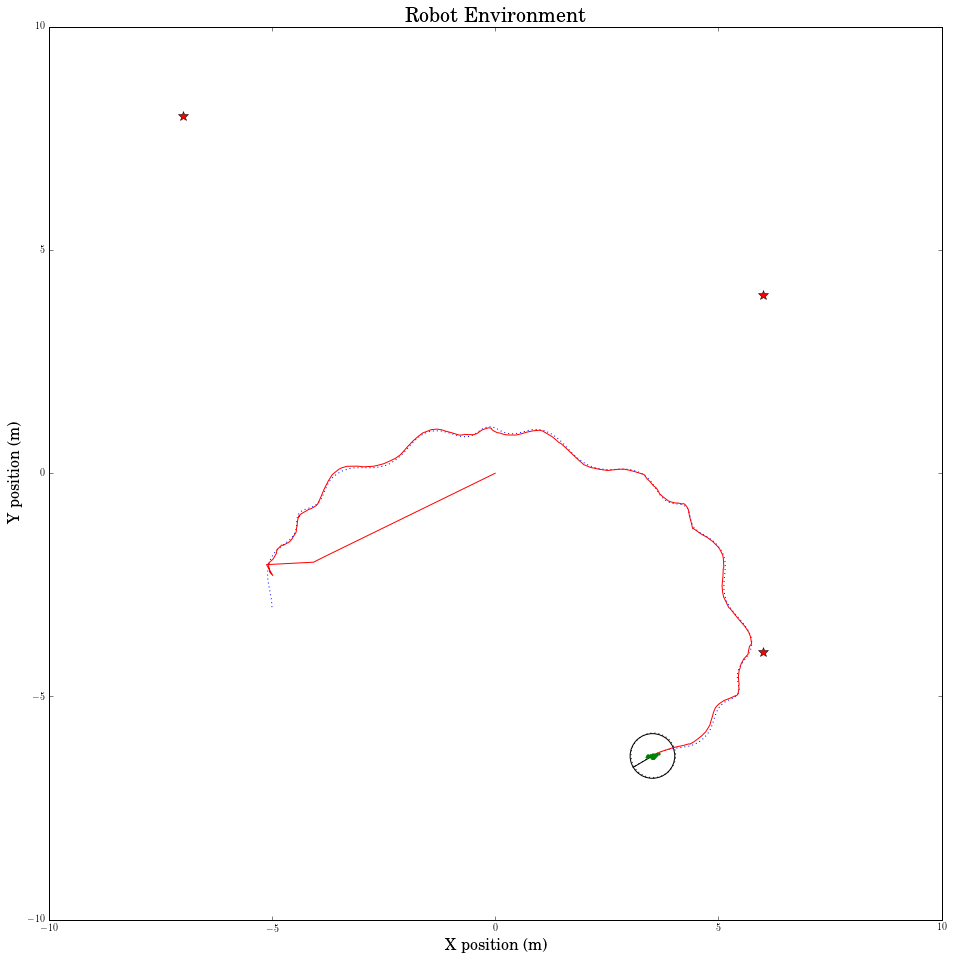

In [46]:
plt.close('all')
env = plt.figure(figsize=(16, 16))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, -1], x[1, -1]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, -1], xHat[1, -1]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, -1])], [0, np.sin(x[2, -1])]])/2
line, = ax.plot(x[0, -1] + direction[0, :], x[1, -1] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, -1])], [0, np.sin(xHat[2, -1])]])/2
lineHat, = ax.plot(xHat[0, -1] + directionHat[0, :], xHat[1, -1] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
truth, = ax.plot(x[0, :], x[1, :], 'b:')
estimate, = ax.plot(xHat[0, :], xHat[1, :], 'r')
particles, = ax.plot(X[0, :, -1], X[1, :, -1], 'go', markersize=2, markeredgewidth=0.0)
plt.show()


In [33]:
plt.close('all')
env = plt.figure(figsize=(8, 8))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, 0], x[1, 0]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, 0], xHat[1, 0]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, 0])], [0, np.sin(x[2, 0])]])/2
line, = ax.plot(x[0, 0] + direction[0, :], x[1, 0] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, 0])], [0, np.sin(xHat[2, 0])]])/2
lineHat, = ax.plot(xHat[0, 0] + directionHat[0, :], xHat[1, 0] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
truth, = ax.plot(x[0, 0], x[1, 0], 'b:')
estimate, = ax.plot(xHat[0, 0], xHat[1, 0], 'r')
particles, = ax.plot(X[0, :, 0], X[1, :, 0], 'go', markersize=1.5, markeredgewidth=0.0)

# cart = np.array([zHat[0, 0]*np.cos(zHat[1, 0]+xHat[2, 0]), zHat[0, 0]*np.sin(zHat[1, 0]+xHat[2, 0])])
# measurement, = ax.plot([xHat[0, 0], xHat[0, 0] + cart[0]], [xHat[1, 0], xHat[1, 0] + cart[1]], 'y--')

# animation function. This is called sequentially
def animate(i):
    direction = np.array([[0, np.cos(x[2, i])], [0, np.sin(x[2, i])]])/2
    line.set_data(x[0, i] + direction[0, :], x[1, i] + direction[1, :])
    robot.center = x[0, i], x[1, i]
    directionHat = np.array([[0, np.cos(xHat[2, i])], [0, np.sin(xHat[2, i])]])/2
    lineHat.set_data(xHat[0, i] + directionHat[0, :], xHat[1, i] + directionHat[1, :])
    robotHat.center = xHat[0, i], xHat[1, i]
    truth.set_data(x[0, :i], x[1, :i])
    estimate.set_data(xHat[0, :i], xHat[1, :i])
    particles.set_data(X[0, :, i], X[1, :, i])
    # measurement to first landmark
#     cart = np.array([zHat[0, i]*np.cos(zHat[1, i]+xHat[2, i]), zHat[0, i]*np.sin(zHat[1, i]+xHat[2, i])])
#     measurement.set_data([xHat[0, i], xHat[0, i] + cart[0]], [xHat[1, i], xHat[1, i] + cart[1]])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
speedup = 0.5
anim = animation.FuncAnimation(env, animate, frames=len(t), interval=Ts*1000/speedup, blit=True)

#print(animation.writers.list())
HTML(anim.to_html5_video())

### Example of Particle Deprivation
Generated with 1000 particles, uniformly initialized over the $([-10, 10], [-10, 10], [-2\pi, 2\pi])$ space.

No method is used to combat the deprivation.

In [15]:
plt.close('all')
env = plt.figure(figsize=(8, 8))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, 0], x[1, 0]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, 0], xHat[1, 0]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, 0])], [0, np.sin(x[2, 0])]])/2
line, = ax.plot(x[0, 0] + direction[0, :], x[1, 0] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, 0])], [0, np.sin(xHat[2, 0])]])/2
lineHat, = ax.plot(xHat[0, 0] + directionHat[0, :], xHat[1, 0] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
truth, = ax.plot(x[0, 0], x[1, 0], 'b:')
estimate, = ax.plot(xHat[0, 0], xHat[1, 0], 'r')
particles, = ax.plot(X[0, :, 0], X[1, :, 0], 'go', markersize=1.5, markeredgewidth=0.0)

# cart = np.array([zHat[0, 0]*np.cos(zHat[1, 0]+xHat[2, 0]), zHat[0, 0]*np.sin(zHat[1, 0]+xHat[2, 0])])
# measurement, = ax.plot([xHat[0, 0], xHat[0, 0] + cart[0]], [xHat[1, 0], xHat[1, 0] + cart[1]], 'y--')

# animation function. This is called sequentially
def animate(i):
    direction = np.array([[0, np.cos(x[2, i])], [0, np.sin(x[2, i])]])/2
    line.set_data(x[0, i] + direction[0, :], x[1, i] + direction[1, :])
    robot.center = x[0, i], x[1, i]
    directionHat = np.array([[0, np.cos(xHat[2, i])], [0, np.sin(xHat[2, i])]])/2
    lineHat.set_data(xHat[0, i] + directionHat[0, :], xHat[1, i] + directionHat[1, :])
    robotHat.center = xHat[0, i], xHat[1, i]
    truth.set_data(x[0, :i], x[1, :i])
    estimate.set_data(xHat[0, :i], xHat[1, :i])
    particles.set_data(X[0, :, i], X[1, :, i])
    # measurement to first landmark
#     cart = np.array([zHat[0, i]*np.cos(zHat[1, i]+xHat[2, i]), zHat[0, i]*np.sin(zHat[1, i]+xHat[2, i])])
#     measurement.set_data([xHat[0, i], xHat[0, i] + cart[0]], [xHat[1, i], xHat[1, i] + cart[1]])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
speedup = 0.5
anim = animation.FuncAnimation(env, animate, frames=len(t), interval=Ts*1000/speedup, blit=True)

#print(animation.writers.list())
HTML(anim.to_html5_video())

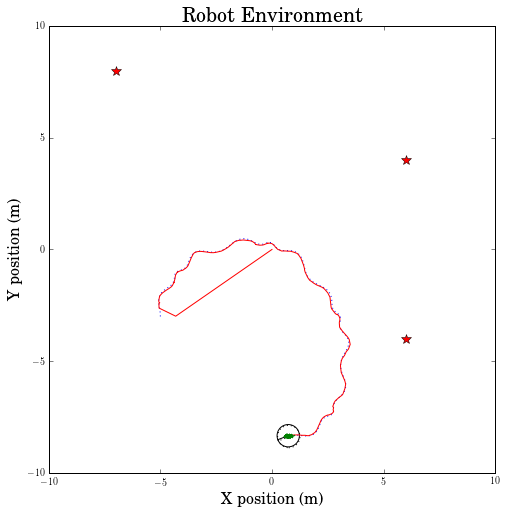

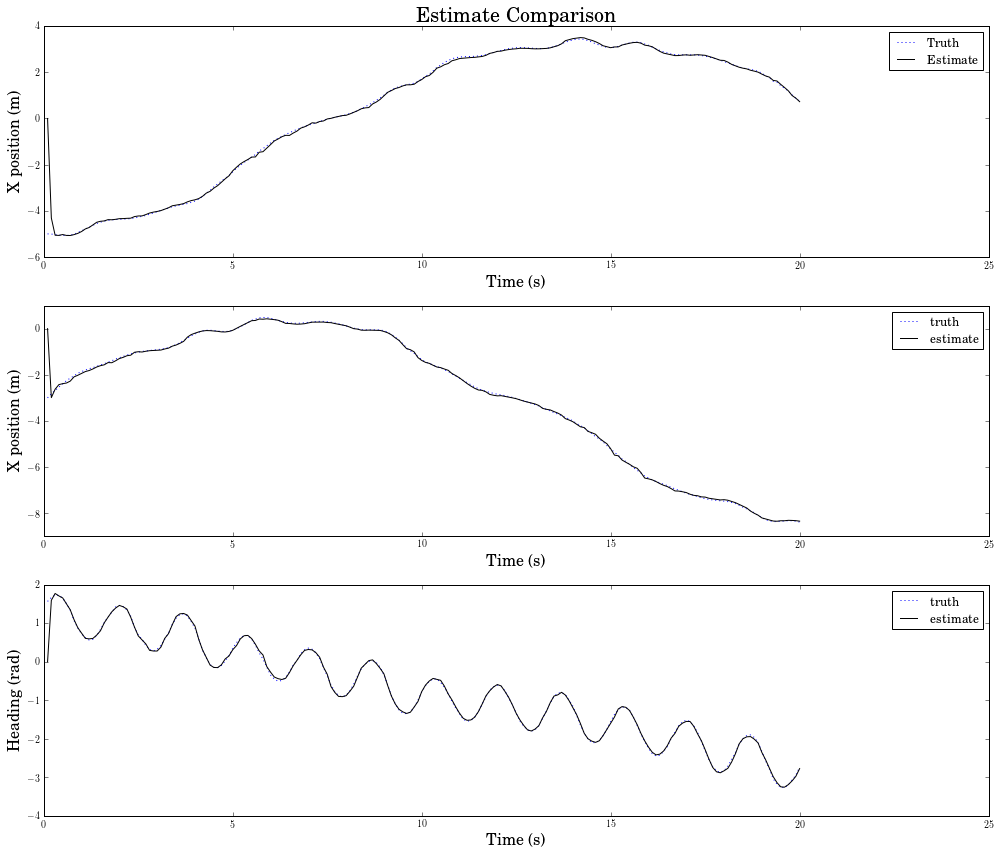

In [9]:
fig = plt.figure(figsize=(14,12))
fig.clear()
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t, x[0, :], 'b:')
ax1.plot(t, xHat[0, :], 'k')
ax1.set_title("Estimate Comparison",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X position (m)", fontsize=16)
ax1.legend(["Truth", "Estimate"])

ax1 = fig.add_subplot(3, 1, 2)
ax1.plot(t, x[1, :], 'b:')
ax1.plot(t, xHat[1, :], 'k')
#ax1.set_title("Y Position",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X position (m)", fontsize=16)

ax1 = fig.add_subplot(3, 1, 3)
ax1.plot(t, x[2, :], 'b:')
ax1.plot(t, xHat[2, :], 'k')
#ax1.set_title("Theta",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Heading (rad)", fontsize=16)

plt.tight_layout()
plt.show()


Error norm = 0.0811657007899


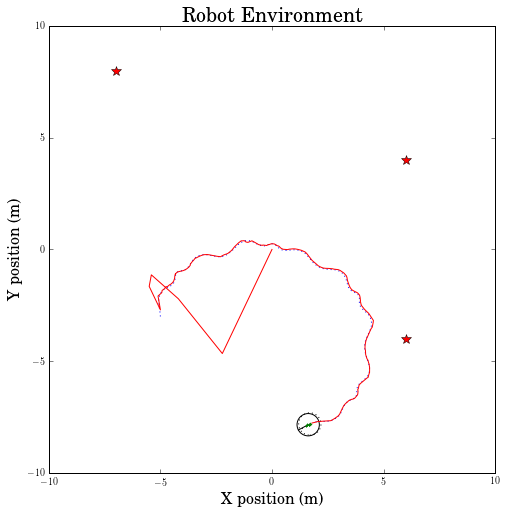

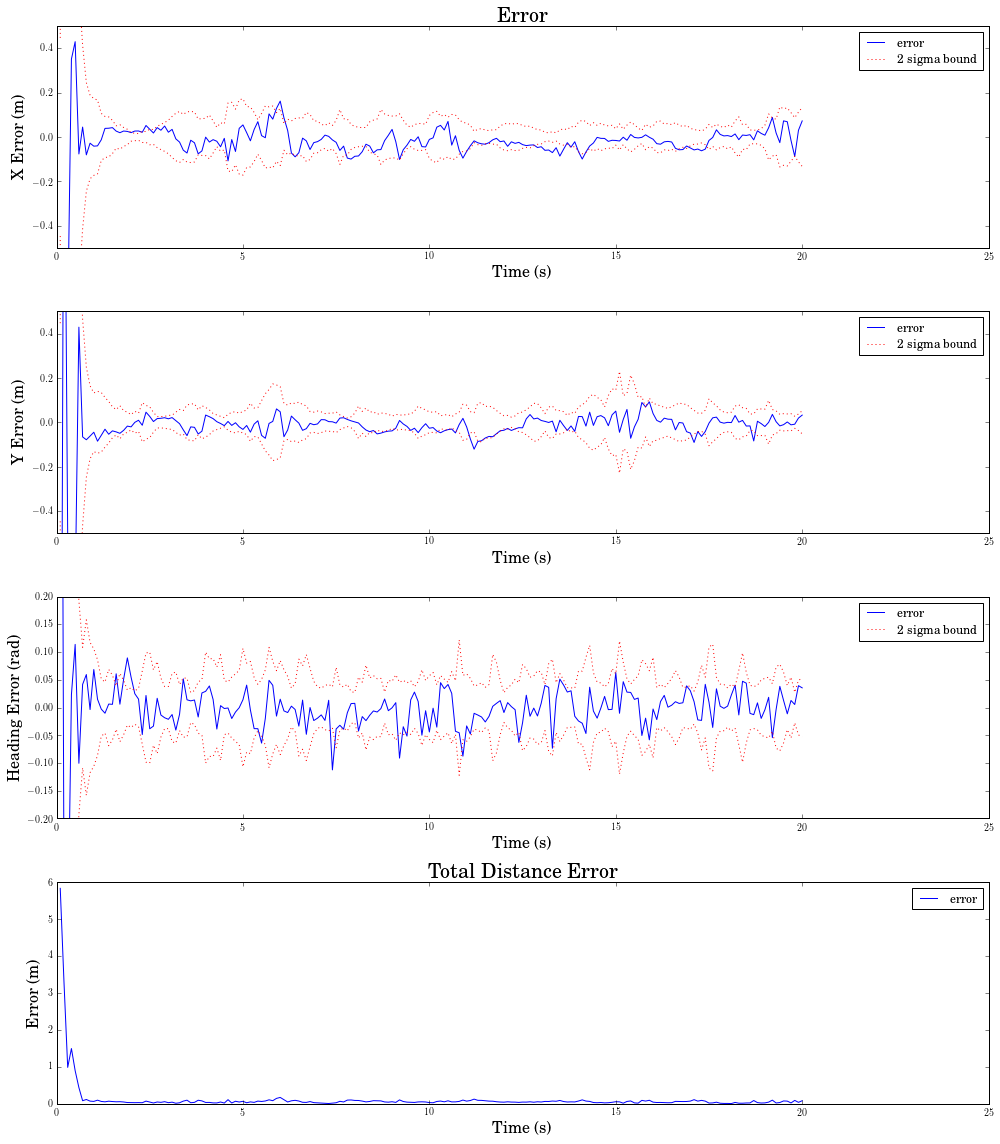

In [34]:
fig = plt.figure(figsize=(14,16))
fig.clear()

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(t, x[0, :] - xHat[0, :])
ax1.plot(t, 2*sig[0, :], 'r:')
ax1.plot(t, -2*sig[0, :], 'r:')
ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X Error (m)", fontsize=16)
ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 2)
ax1.plot(t, x[1, :] - xHat[1, :])
ax1.plot(t, 2*sig[1, :], 'r:')
ax1.plot(t, -2*sig[1, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Y Error (m)", fontsize=16)
ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 3)
ax1.plot(t, x[2, :] - xHat[2, :])
ax1.plot(t, 2*sig[2, :], 'r:')
ax1.plot(t, -2*sig[2, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Heading Error (rad)", fontsize=16)
ax1.set_ylim([-0.2, 0.2])

ax1 = fig.add_subplot(4, 1, 4)
e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))
ax1.plot(t, e)
ax1.set_title("Total Distance Error",fontsize=20)
ax1.legend(["error"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Error (m)", fontsize=16)

print("Error norm = {}".format(np.linalg.norm(e[10:])*Ts))

plt.tight_layout()
plt.show()

## Questions

* Q: How does the the system behave with poor initial conditions?
* A: The system converges within a few time steps, even with very poor initial conditions.

* Q: How does the system behave with changes in process/noise convariances?
* A: Increasing measurement noise increases estimation error and decreases the Kalman gains. Increasing process noise increases noise in truth, but marginally decreases estimation error. 

* Q: What happens to the quality of your estimates if you reduce the number of landmarks? increase?
* A: Fewer landmarks degrades the estimate. More landmarks marginally improves the localization unless the robot gets too close to a landmark, then it can cause it to diverge.

In [15]:
from tqdm import trange

Ts = 1
Tend = 20

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
x[:, 0] = np.array([-5, -3, np.pi/2])

N = 100
e = np.zeros(N)

for j in trange(N):
    # generate truth data
    #print("You can't handle the truth...")
    for i in xrange(1, len(t)):
        x[:, i:i+1] = f(x[:, i-1:i], u[:, i:i+1], Ts)


    xHat = np.zeros_like(x)
    xHat[:, 0] = x[:, 0]
    sig = np.zeros_like(x)
    sig[:, 0] = np.sqrt(P.diagonal())
    K = np.zeros((3, 2, len(t)-1))
    input_dim = u.shape[0]
    measure_dim = 2
    #x0, input_dim, measure_dim, f, g, R, P, Ts, Q=None, Qu=None, alpha=1.0, beta=2.0, kappa=0.0)
    ukf = UKF(xHat[:, 0], input_dim, measure_dim, f, g, R, P, Ts, Qu=Qu, alpha=0.5, beta=2.0, kappa=0.1)

    zHat = np.zeros((2, len(t)))

    for i in xrange(1, len(t)):
        uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
        ukf.predict(uHat)
        for landmark in landmarks.T:
            z = g(x[:, i:i+1], landmark) + np.random.multivariate_normal([0, 0], R)[:, np.newaxis]
            ukf.update(z, landmark)

    #     landmark = landmarks[:, 0]
    #     z = g(x[:, i:i+1], landmark) + np.random.multivariate_normal([0, 0], R)[:, np.newaxis]
        ukf.update(z, landmark)
        xHat[:, i:i+1] = ukf.x
        #K[:, :, i-1] = ukf.K
        sig[:, i] = np.sqrt(ukf.P.diagonal())
    
    e[j] = np.linalg.norm(np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2)))

print("Over {} runs:".format(N))
print("Mean error norm = {}".format(np.mean(e*Ts)))
print("Standard deviation of error norm = {}".format(np.std(e*Ts)))
    


100%|██████████| 100/100 [00:01<00:00, 55.64it/s]

Over 100 runs:
Mean error norm = 0.511231240526
Standard deviation of error norm = 0.093367870726


In [9]:
print(np.mean(e)*Ts)
print(1/5.40)
print(6.66/5.31)
print(e)

12.3993946212
0.185185185185
1.25423728814
[ 61.99724243  61.99692473  61.99601281  61.99630311  61.99807556
  61.99737738  61.99595491  61.99844888  61.99694005  61.9983962
  61.99725627  61.99736793  61.99657526  61.99689273  61.99633104
  61.99905919  61.99752214  61.99656653  61.99884118  61.99585179
  61.99711598  61.99733734  61.99617065  61.99670452  61.99876794
  61.99623198  61.99570438  61.99759652  61.99739536  61.9977181
  61.99722455  61.99716312  61.99697566  61.9980101   61.99630668
  61.99678467  61.99837994  61.996037    61.99609792  61.99578825
  61.99812336  61.99659878  61.99743852  61.9971557   61.99649964
  61.99745203  61.99725214  61.99773552  61.99626842  61.99716939
  61.99680392  61.99619436  61.99676058  61.99684127  61.9961233
  61.99599636  61.99675271  61.99807651  61.9970371   61.9957028
  61.99856789  61.9988075   61.9971393   61.99648269  61.99715683
  61.99766285  61.99684935  61.99684666  61.99655612  61.99636043
  61.99820224  61.99760356  61.995634

## Monte Carlo comparison of the EKF vs the UKF
The performances of the EKF and UKF are compared over 10,000 runs of the above ground robot simulation with identical landmarks and input characteristics (only differing by noise from run to run).

Using an Intel i7-6700HQ processor, a time step of 0.1s and a simulation duration of 20s, 10,000 simulations were completed. Here is the performance comparison:

Algorithm | Runtime Per Simulation (s)
--- | ---
EKF | 0.150
UKF | 0.188

The EKF runs 25% faster. This gap could probably be reduced with some optimizations of the UKF. For example, the Cholesky factorization of a matrix is $O(n^3)$ and is a significant computational burden of the UKF, but the factorization of a block diagonal matrix (such as the augmented covariance matrix) results in a block diagonal matrix, meaning that the factorization could be broken up into smaller pieces. If the augmented covariance matrix is of size $L=n+m+p$, where $n$ is the state dimension, $m$ is the input dimension, and $p$ is the measurement dimension; then the factorization could be optimized from $O((n+m+p)^3)$ to $O(n^3+m^3+p^3)$.

The localization error was calculated as the cartesian distance from the robot's true location to the estimated location (ignoring heading). The following table compares the $C_2$ norms of the average error over the 10,000 runs:

Algorithm | $C_2$ Norm of Error | Standard Deviation
--- | --- | ---
EKF | 0.0778 | 0.0064
UKF | 0.0793 | 0.0062

This implies that for this dynamic model and measurement model, the EKF provides a marginally more accurate (2.5%) result and a faster run time (25%).